<a href="https://colab.research.google.com/github/Phionanamugga/Autonomous_Navigation/blob/main/ObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!wget -c https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip


--2025-08-12 08:33:18--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 3.5.137.71, 3.5.138.189, 52.219.47.75, ...
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|3.5.137.71|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [25]:
!wget -c https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip

--2025-08-12 08:33:24--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 3.5.136.37, 3.5.138.208, 52.219.170.65, ...
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|3.5.136.37|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [26]:
!unzip -q '*.zip'

replace 2011_10_03/calib_cam_to_cam.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace 2011_10_03/calib_imu_to_velo.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace 2011_10_03/calib_velo_to_cam.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [27]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import torch
import cv2

In [28]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

In [29]:
!wget https://github.com/itberrios/CV_tracking/raw/main/kitti_tracker/kitti_utils.py

--2025-08-12 08:34:11--  https://github.com/itberrios/CV_tracking/raw/main/kitti_tracker/kitti_utils.py
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/itberrios/CV_tracking/main/kitti_tracker/kitti_utils.py [following]
--2025-08-12 08:34:11--  https://raw.githubusercontent.com/itberrios/CV_tracking/main/kitti_tracker/kitti_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9759 (9.5K) [text/plain]
Saving to: ‘kitti_utils.py.1’

kitti_utils.py.1    100%[===================>]   9.53K  --.-KB/s    in 0s      

2025-08-12 08:34:12 (29.7 MB/s) - ‘kitti_utils.py.1’ saved [9759/9759]



In [30]:
DATA_PATH = r'2011_10_03/2011_10_03_drive_0047_sync'
# get RGB camera data
left_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_02/data/*png')))
right_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_03/data/*png')))

# getting LiDAR data
bin_paths = sorted(glob(os.path.join(DATA_PATH, 'velodyne_points/data/*bin')))

# Get GPS/IMU data
oxts_paths = sorted(glob(os.path.join(DATA_PATH, r'oxts/data/*txt')))

print(f'Number of RGB images: {len(left_image_paths)}')
print(f'Number of RGB images: {len(right_image_paths)}')
print(f'Number of LiDAR points: {len(bin_paths)}')
print(f'Number of GPS/IMU data: {len(oxts_paths)}')

Number of RGB images: 837
Number of RGB images: 837
Number of LiDAR points: 837
Number of GPS/IMU data: 837


In [31]:
# Loading camera calibration data
with open('2011_10_03/calib_cam_to_cam.txt', 'r') as f:
    calib = f.readlines()

# Get projection matrices (rectified left camera ---> left camera (u,v,z))
p_rect_cam2 = np.array([float(x) for x in calib[25].strip().split()[1:]]).reshape(3, 4)

# Get rectified rotation matrices (left camera ---> rectified left camera)
R_ref_rect2 = np.array([float(x) for x in calib[24].strip().split()[1:]]).reshape(3, 3)

# Add (0,0,0) translation and convert to homogeneous coordinates
R_ref_rect2 = np.insert(R_ref_rect2, 3, values=[0,0,0], axis=1)
R_ref_rect2 = np.insert(R_ref_rect2, 3, values=[0,0,0,1], axis=0)

# Get rigid transformation from camera 0 (ref) to camera 2
R_2 = np.array([float(x) for x in calib[21].strip().split()[1:]]).reshape(3, 3)
t_2 = np.array([float(x) for x in calib[22].strip().split()[1:]]).reshape(3, 1)

# Get cam0 to cam2 rigid body transformation in homogeneous coordinates
T_Cam0_cam2 = np.insert(np.hstack((R_2, t_2)), 3, values=[0,0,0,1], axis=0)

In [32]:

def get_rigid_transformation(calib_path):
    with open(calib_path, 'r') as f:
        calib = f.readlines()
    R = np.array([float(x) for x in calib[1].strip().split()[1:]]).reshape(3, 3)
    t = np.array([float(x) for x in calib[2].strip().split()[1:]])[:, None]
    T = np.vstack((np.hstack((R, t)), [0, 0, 0, 1]))
    return T

# Define T_velo_ref
T_velo_ref = get_rigid_transformation(r'2011_10_03/calib_velo_to_cam.txt')

# Print to verify
print("T_velo_ref (LiDAR to Camera):\n", T_velo_ref)

T_velo_ref (LiDAR to Camera):
 [[ 7.967514e-03 -9.999679e-01 -8.462264e-04 -1.377769e-02]
 [-2.771053e-03  8.241710e-04 -9.999958e-01 -5.542117e-02]
 [ 9.999644e-01  7.969825e-03 -2.764397e-03 -2.918589e-01]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]]


In [33]:
# Function to load rigid body transformation from calibration file
def get_rid_transformation(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Calibration file not found: {file_path}")
    with open(file_path, 'r') as f:
        calib = f.readlines()
    R, t = None, None
    for line in calib:
        if line.startswith('R:'):
            R = np.array([float(x) for x in line.strip().split()[1:]]).reshape(3, 3)
        elif line.startswith('T:') or line.startswith('t:'):
            t = np.array([float(x) for x in line.strip().split()[1:]]).reshape(3, 1)
    if R is None or t is None:
        raise ValueError(f"Invalid format in {file_path}: 'R:' or 'T:'/'t:' not found")
    T = np.vstack((np.hstack((R, t)), [0, 0, 0, 1]))
    return T

# Loading camera calibration data
calib_file = '2011_10_03/calib_cam_to_cam.txt'
if not os.path.exists(calib_file):
    raise FileNotFoundError(f"Calibration file not found: {calib_file}")
with open(calib_file, 'r') as f:
    calib = f.readlines()

# Get projection matrices (rectified left camera ---> left camera (u,v,z))
p_rect_cam2 = np.array([float(x) for x in calib[25].strip().split()[1:]]).reshape(3, 4)

# Get rectified rotation matrices (left camera ---> rectified left camera)
R_ref_rect2 = np.array([float(x) for x in calib[24].strip().split()[1:]]).reshape(3, 3)

# Add (0,0,0) translation and convert to homogeneous coordinates
R_ref_rect2 = np.insert(R_ref_rect2, 3, values=[0,0,0], axis=1)
R_ref_rect2 = np.insert(R_ref_rect2, 3, values=[0,0,0,1], axis=0)

# Get rigid transformation from camera 0 (ref) to camera 2
R_2 = np.array([float(x) for x in calib[21].strip().split()[1:]]).reshape(3, 3)
t_2 = np.array([float(x) for x in calib[22].strip().split()[1:]]).reshape(3, 1)

# Get cam0 to cam2 rigid body transformation in homogeneous coordinates
T_Cam0_cam2 = np.vstack((np.hstack((R_2, t_2)), [0,0,0,1]))

# Loading LiDAR calibration data
T_velo_ref = get_rid_transformation('2011_10_03/calib_velo_to_cam.txt')

# Skip loading T_velo_imu since the file is missing and not used in transformations
# If needed, uncomment and ensure the file exists:
# T_velo_imu = get_rid_transformation('2011_10_03/calib_velo_to_imu.txt')

# Transform from Velodyne LiDAR to left color camera (shape 3x4)
T_velo_cam2 = p_rect_cam2 @ R_ref_rect2 @ T_Cam0_cam2 @ T_velo_ref

# Homogeneous transform from left color camera to Velodyne LiDAR (shape 4x4)
T_cam2_velo = np.linalg.inv(np.vstack((T_velo_cam2, [0,0,0,1])))

# Print results
print("T_velo_cam2 (LiDAR to left color camera, 3x4):\n", T_velo_cam2)
print("T_cam2_velo (left color camera to LiDAR, 4x4):\n", T_cam2_velo)

T_velo_cam2 (LiDAR to left color camera, 3x4):
 [[ 6.07484390e+02 -7.18537361e+02 -1.01875822e+01 -9.55729189e+01]
 [ 1.80027463e+02  5.89922104e+00 -7.20148711e+02 -9.34570810e+01]
 [ 9.99973895e-01  4.85949260e-04 -7.20693419e-03 -2.84637351e-01]]
T_cam2_velo (left color camera to LiDAR, 4x4):
 [[ 5.94945492e-07 -1.00306966e-05  1.00147052e+00  2.84175339e-01]
 [-1.39105363e-03  1.12417451e-05  8.43041553e-01  1.08064679e-01]
 [-1.12463249e-05 -1.39101753e-03  2.57260040e-01 -5.78494660e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [34]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 17521, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 17521 (delta 9), reused 0 (delta 0), pack-reused 17497 (from 4)
Receiving objects: 100% (17521/17521), 16.61 MiB | 22.67 MiB/s, done.
Resolving deltas: 100% (11998/11998), done.


In [37]:
!pip install -r yolov5/requirements.txt

  Using cached thop-0.1.1.post2209072238-py3-none-any.whl.metadata (2.7 kB)
  Using cached ultralytics-8.3.177-py3-none-any.whl.metadata (37 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.wh

In [39]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-8-12 Python-3.11.13 torch-2.6.0+cu124 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [57]:
# set confidence and IOU thresholds
model.conf = 0.25 # confidence threshold(0.1) ,default:0.25
model.iou = 0.25 # NMS IOU threshold for NMS(0.45)

In [58]:
detections = model(left_image_paths[0])

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


In [59]:

def get_uvz_centers(image, velo_uvz, bboxes, draw=True):
    # Unpack LiDAR camera coordinates
    u, v, z = velo_uvz[:, 0], velo_uvz[:, 1], velo_uvz[:, 2]

    # Initialize output array: bboxes + 3 columns for (u, v, z)
    bboxes_out = np.zeros((bboxes.shape[0], bboxes.shape[1] + 3))
    bboxes_out[:, :bboxes.shape[1]] = bboxes  # Copy original bboxes

    # Iterate through all detected bounding boxes
    for i, bbox in enumerate(bboxes):
        # Convert bbox coordinates to integers
        pt1 = torch.round(bbox[0:2]).to(torch.int).numpy()  # (y_min, x_min)
        pt2 = torch.round(bbox[2:4]).to(torch.int).numpy()  # (y_max, x_max)

        # Get center location of the object on the image
        obj_x_center = (pt1[1] + pt2[1]) / 2  # x center
        obj_y_center = (pt1[0] + pt2[0]) / 2  # y center

        # Compute distance from LiDAR points to the center
        center_delta = np.abs(np.vstack((u, v)).T - np.array([obj_x_center, obj_y_center]))

        # Choose coordinate pair with the smallest L2 norm
        min_loc = np.argmin(np.linalg.norm(center_delta, axis=1))

        # Get LiDAR location in image/camera space
        velo_depth = z[min_loc]
        uvz_location = np.array([u[min_loc], v[min_loc], velo_depth])

        # Add velo projections (u, v, z) to bboxes_out
        bboxes_out[i, -3:] = uvz_location

        # Draw depth on image at center of each bounding box
        if draw:
            object_center = (int(np.round(obj_x_center)), int(np.round(obj_y_center)))
            cv2.putText(
                image,
                '{:.2f} m'.format(velo_depth),
                object_center,  # Center of bounding box
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (255, 0, 0),  # Blue color in BGR
                2,
                cv2.LINE_AA
            )

    return bboxes_out

In [60]:
def get_detection_coordinates(image, bin_path, draw_boxes=True, draw_depth =True):
    # compute detections in the left image
    detections = model(left_image_paths[0])

    # draw boxes on images
    if draw_boxes:
        detections.show()


    # get bounding box locations
    bboxes = detections.xyxy[0].cpu().numpy()

    velo_uvz = project_velobin2uvz(bin_path,
                                   T_velo_cam2,
                                   left_image,
                                   remove_plane = True)

    # get uvz centers for detected objects
    bboxes_out = get_uvz_centers(image, velo_uvz, bboxes, draw=draw_depth)

    return bboxes, velo_uvz

In [61]:
!pip install pymap3d

In [62]:
import pymap3d as pm
def imu2geodetic(x,y,z, lat0, lon0, alt0, heading0):

  # convert to RAE
  rng = np.sqrt(x**2 + y**2 + z**2)
  az = np.degrees(np.arctan2(y,x)) + np.degrees(heading0)
  el = np.degrees(np.arctan2(np.sqrt(x**2 + y**2), z)) + 90

  # convert to geodetic
  lla = pm.geodetic2ned(az, el, rng,lat0, lon0, alt0)

  # convert to numpy array
  lla = np.vstack((lla[0], lla[1], lla[2])).T
  return lla


In [63]:
def project_velobin2uvz(bin_path, T_velo_cam, image):
    points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)[:, :3]
    points_hom = np.hstack((points, np.ones((points.shape[0], 1))))
    points_cam = (T_velo_cam @ points_hom.T).T
    return points_cam[:, :3]

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


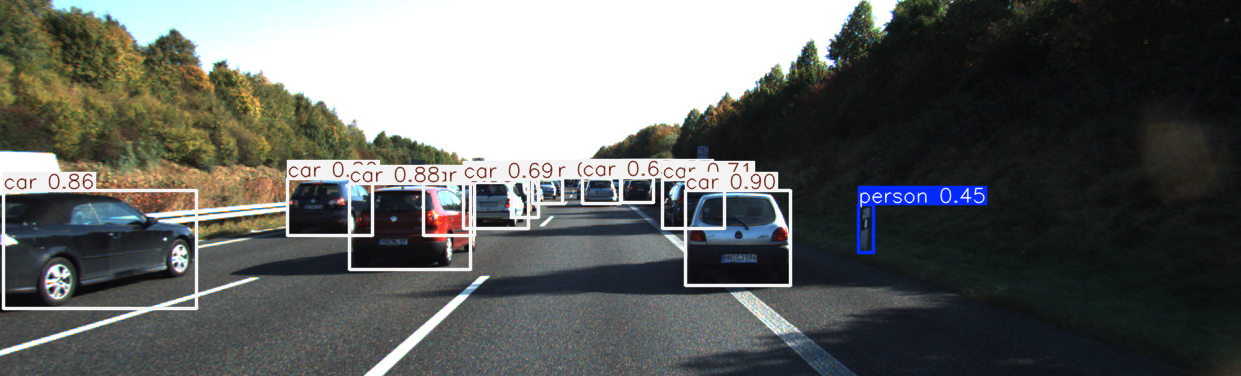

TypeError: project_velobin2uvz() got an unexpected keyword argument 'remove_plane'

In [64]:
import cv2
import numpy as np
from kitti_utils import get_oxts  # Import the get_oxts function

# Testing the pipeline
index = 10
left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
bin_path = bin_paths[index]
oxts_frame = get_oxts(oxts_paths[index])  # Parse GPS/IMU data

# Get detections and object centers in uvz
bboxes, velo_uvz = get_detection_coordinates(left_image, bin_path, draw_boxes=True, draw_depth=True)

# Get transformed coordinates of object centers
uvz = bboxes[:, -3:]

# Transform to (u,v,z) in IMU frame
imu_uvz = transform_uvz(uvz, T_cam2_imu)

# Get Lat/Long/Alt for each detected object
lat0 = oxts_frame[0]
lon0 = oxts_frame[1]
alt0 = oxts_frame[2]
heading0 = oxts_frame[5]

lla = imu2geodetic(imu_uvz[:,0], imu_uvz[:,1], imu_uvz[:,2], lat0, lon0, alt0, heading0)

# Print results (optional)
print("Geodetic coordinates (lat, lon, alt):\n", lla)

In [66]:
def draw_velo_on_image(velo_uvz, image):
    # Copy image to avoid modifying the original
    img = image.copy()
    # Draw LiDAR points as circles on the image
    for point in velo_uvz:
        u, v, z = point
        if z > 0:  # Ensure point is in front of camera
            u, v = int(u), int(v)
            if 0 <= u < img.shape[1] and 0 <= v < img.shape[0]:  # Check bounds
                cv2.circle(img, (u, v), 2, (255, 0, 0), -1)  # Draw blue dot
    return img

In [67]:
velo_image = draw_velo_on_image(velo_uvz, np.zeros_like(left_image))

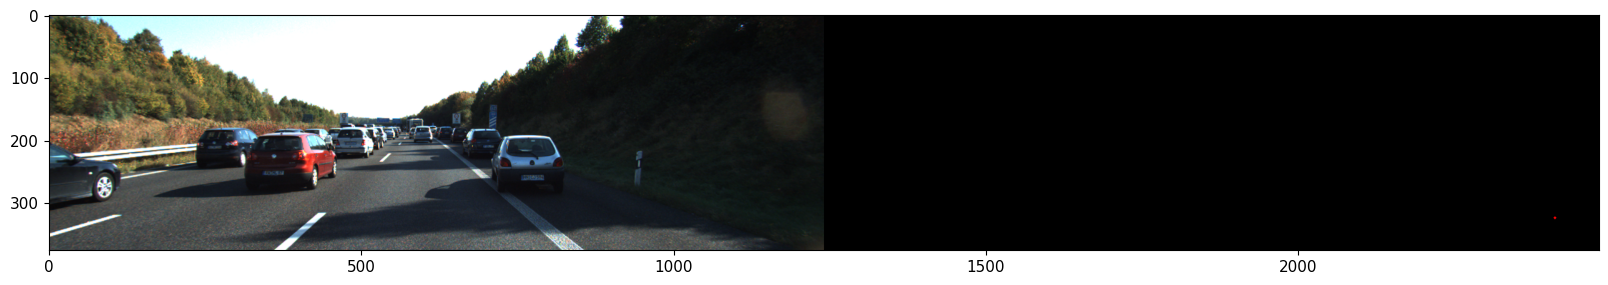

In [68]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

# stack image with LiDAR point cloud
stacked = np.hstack((left_image, velo_image))

# show image
plt.imshow(stacked)

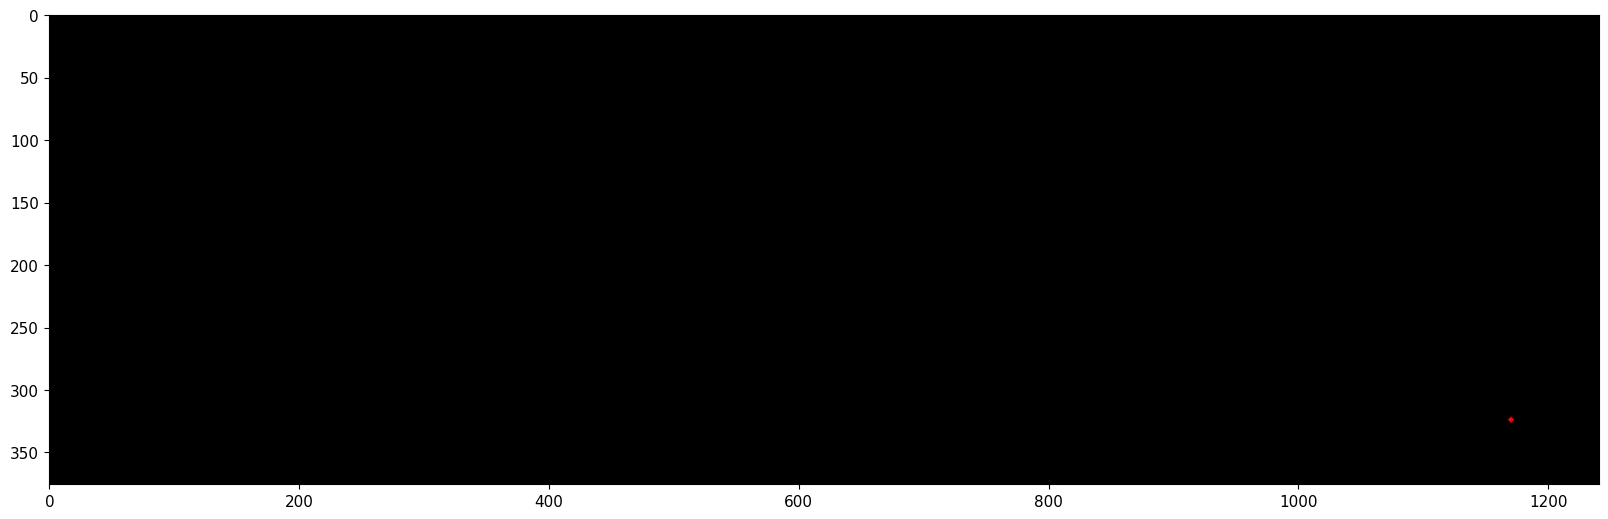

In [69]:
left_image_2 = cv2.cvtColor(cv2.imread(left_image_paths[index+1]),cv2.COLOR_BGR2RGB)
velo_image_2 = draw_velo_on_image(velo_uvz, np.zeros_like(left_image_2))
plt.imshow(velo_image_2);

In [70]:
imu_xyz

NameError: name 'imu_xyz' is not defined

In [ ]:
uvz

In [ ]:
(uvz[:,2]+ 1.08) - imu_xyz[:,0]

In [ ]:
import follum
drive_map = follum.Map(
    location = (lat0, lon0),
    zoom_start = 18,
)

# add lat/lon points to map
follum.CircleMarker(location=(lat0, lon0),
                    radius=2,
                    weight=5,
                    color ='red').add_to(drive_map);

In [ ]:
# place the position of each detection on the map
for pos in lla:
  follum.CircleMarker(location=(pos[0],pos[1]),
                      radius =2,
                      weight =5,
                      color ='green').add_to(drive_map);



In [ ]:
drive_map

In [ ]:
canvas_height = stacked.shape[0]
canvas_width = 500

In [ ]:
import mmcv
print(mmcv.__version__)  # Should print 2.1.0
import mmdet
import mmdet3d
print(mmdet.__version__, mmdet3d.__version__)  # Should print 3.3.0, 1.4.0

In [ ]:
from mmdet3d.datasets import build_dataset
cfg.data.train.data_root = './data/kitti/'
dataset = build_dataset(cfg.data.train)

In [ ]:

model = torch.hub.load('pytorch/vision:v0.15.2', 'deeplabv3_resnet101', pretrained=True)
model.eval()


In [ ]:
import torchvision.transforms as T
from PIL import Image
import numpy as np

transform = T.Compose([T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406],
                                               std=[0.229, 0.224, 0.225])])

def segment_image(image_path):
    img = Image.open(image_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0)
    with torch.no_grad():
        output = model(input_tensor)['out'][0]
    sem_prob = torch.softmax(output, dim=0).cpu().numpy()  # shape: [21, H, W]
    return sem_prob


In [ ]:
import numpy as np

def project_lidar_to_image(points, calib):
    # points: Nx3 array (x,y,z)
    # calib: calibration matrix from KITTI
    # Return: Nx2 array of pixel coordinates
    pts_3d = np.hstack((points, np.ones((points.shape[0],1))))
    pts_2d = calib @ pts_3d.T
    pts_2d[:2, :] /= pts_2d[2, :]
    return pts_2d[:2, :].T  # Nx2 pixel coordinates